In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
file_path = 'your_data.csv'
df = pd.read_csv(file_path)

we dropped the unnamed column which carries their index<br>
we also dropped the hearing feature because it is irrelevent

In [ ]:
df=df.drop('Unnamed: 0',axis=1)
df=df.drop('hearing(right)',axis=1)

we separated the data into target and features to perform analysis on features

In [ ]:
target_column = df['smoking']
features_columns = df.columns[df.columns != 'smoking']
features_df = df[features_columns]

we normalized the data using standard scaler to make the data coherent

In [ ]:
scaler = StandardScaler()
normalized_features = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)

**<h1>Univariate Analysis**

In [ ]:
feature_stats = features_df.describe()
print("Feature Statistics:\n", feature_stats)

Feature Statistics:
        fasting blood sugar       systolic            ALT      waist(cm)  \
count        159256.000000  159256.000000  159256.000000  159256.000000   
mean             98.352552     122.503648      26.550296      83.001990   
std              15.329740      12.729315      17.753070       8.957937   
min              46.000000      77.000000       1.000000      51.000000   
25%              90.000000     114.000000      16.000000      77.000000   
50%              96.000000     121.000000      22.000000      83.000000   
75%             103.000000     130.000000      32.000000      89.000000   
max             375.000000     213.000000    2914.000000     127.000000   

                 LDL    Cholesterol     height(cm)            AST  \
count  159256.000000  159256.000000  159256.000000  159256.000000   
mean      114.607682     195.796165     165.266929      25.516853   
std        28.158931      28.396959       8.818970       9.464882   
min         1.000000      7

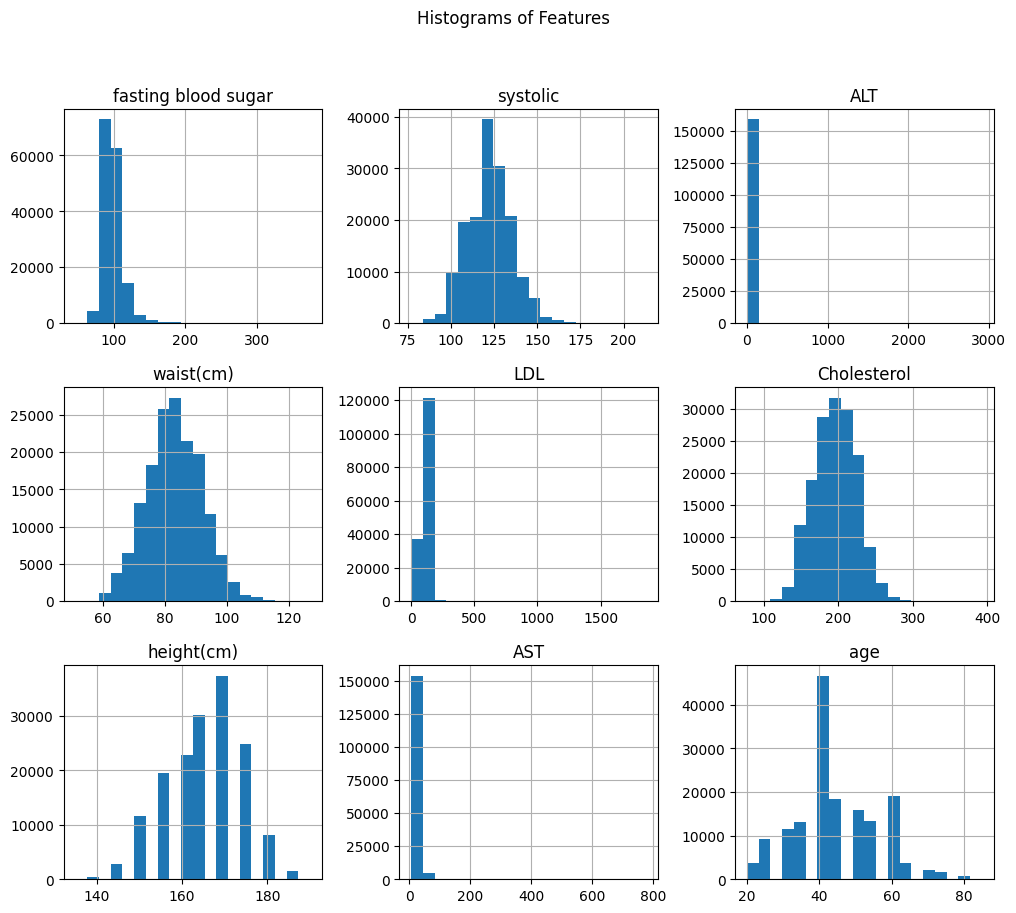

In [ ]:
features_df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Features')
plt.show()

In [ ]:
z_score_threshold = 5
# Identify outliers based on z-score
outliers = (abs(normalized_features) > z_score_threshold).any(axis=1)
# Drop rows containing outliers
filtered_features = normalized_features[~outliers]
filtered_targets = target_column[~outliers]
filtered_features.reset_index(drop=True, inplace=True)
filtered_targets.reset_index(drop=True, inplace=True)

we will drop the outliers by applying threshold=5 and reseting the index

In [ ]:
print('Number of samples before and after dropping outliers')
print(len(normalized_features))
print(len(filtered_features))

Number of samples before and after dropping outliers
159256
157853


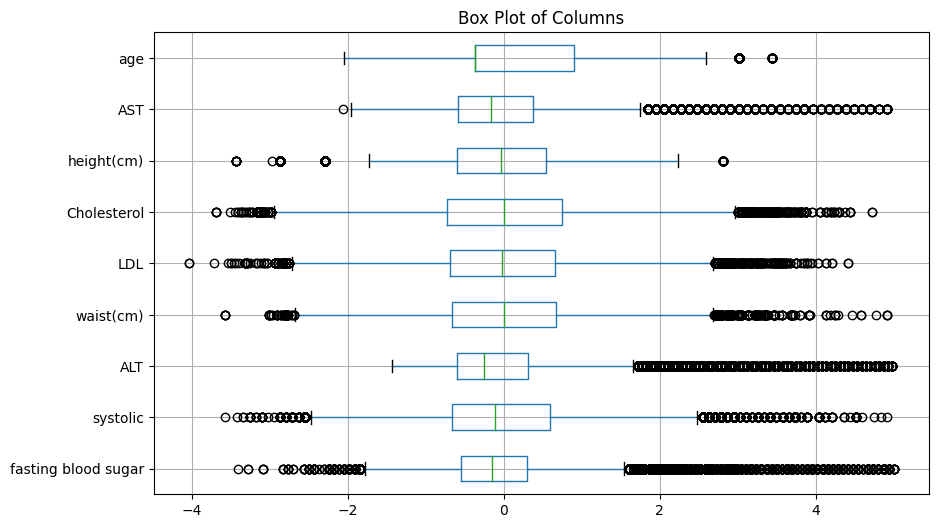

In [ ]:
plt.figure(figsize=(10, 6))
filtered_features[filtered_features.columns].boxplot(vert=False)
plt.title('Box Plot of Columns')
plt.show()

this is the box plot to show the distribution of the data and the quantiles

**<h1>Bivariate analysis**

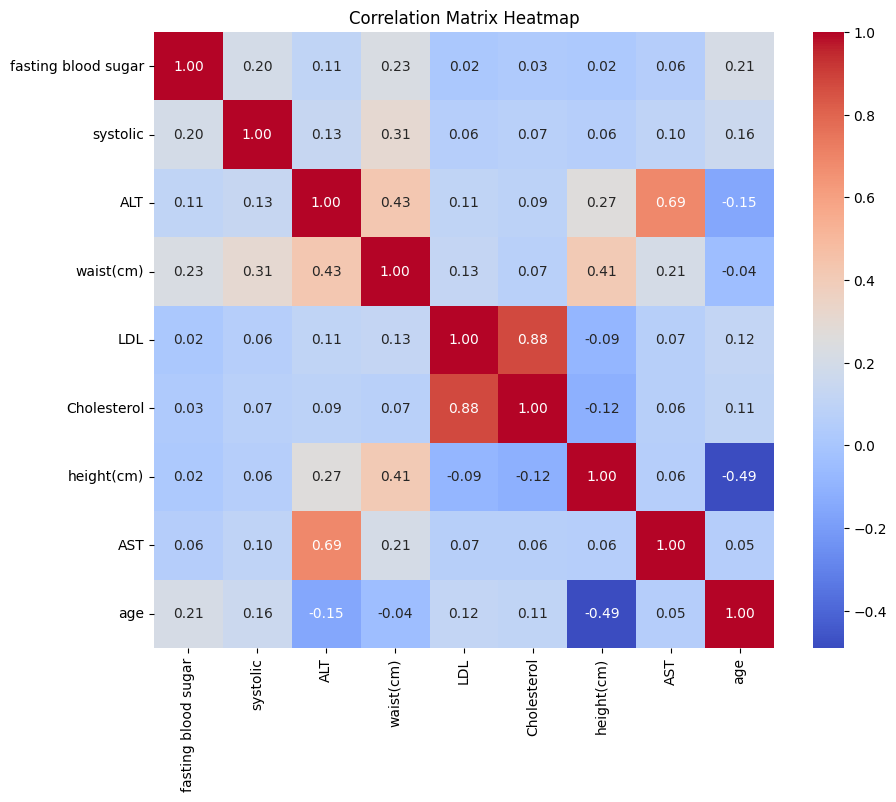

In [ ]:
correlation_matrix = filtered_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

correlation graph that shows how much correlated is every pair of features

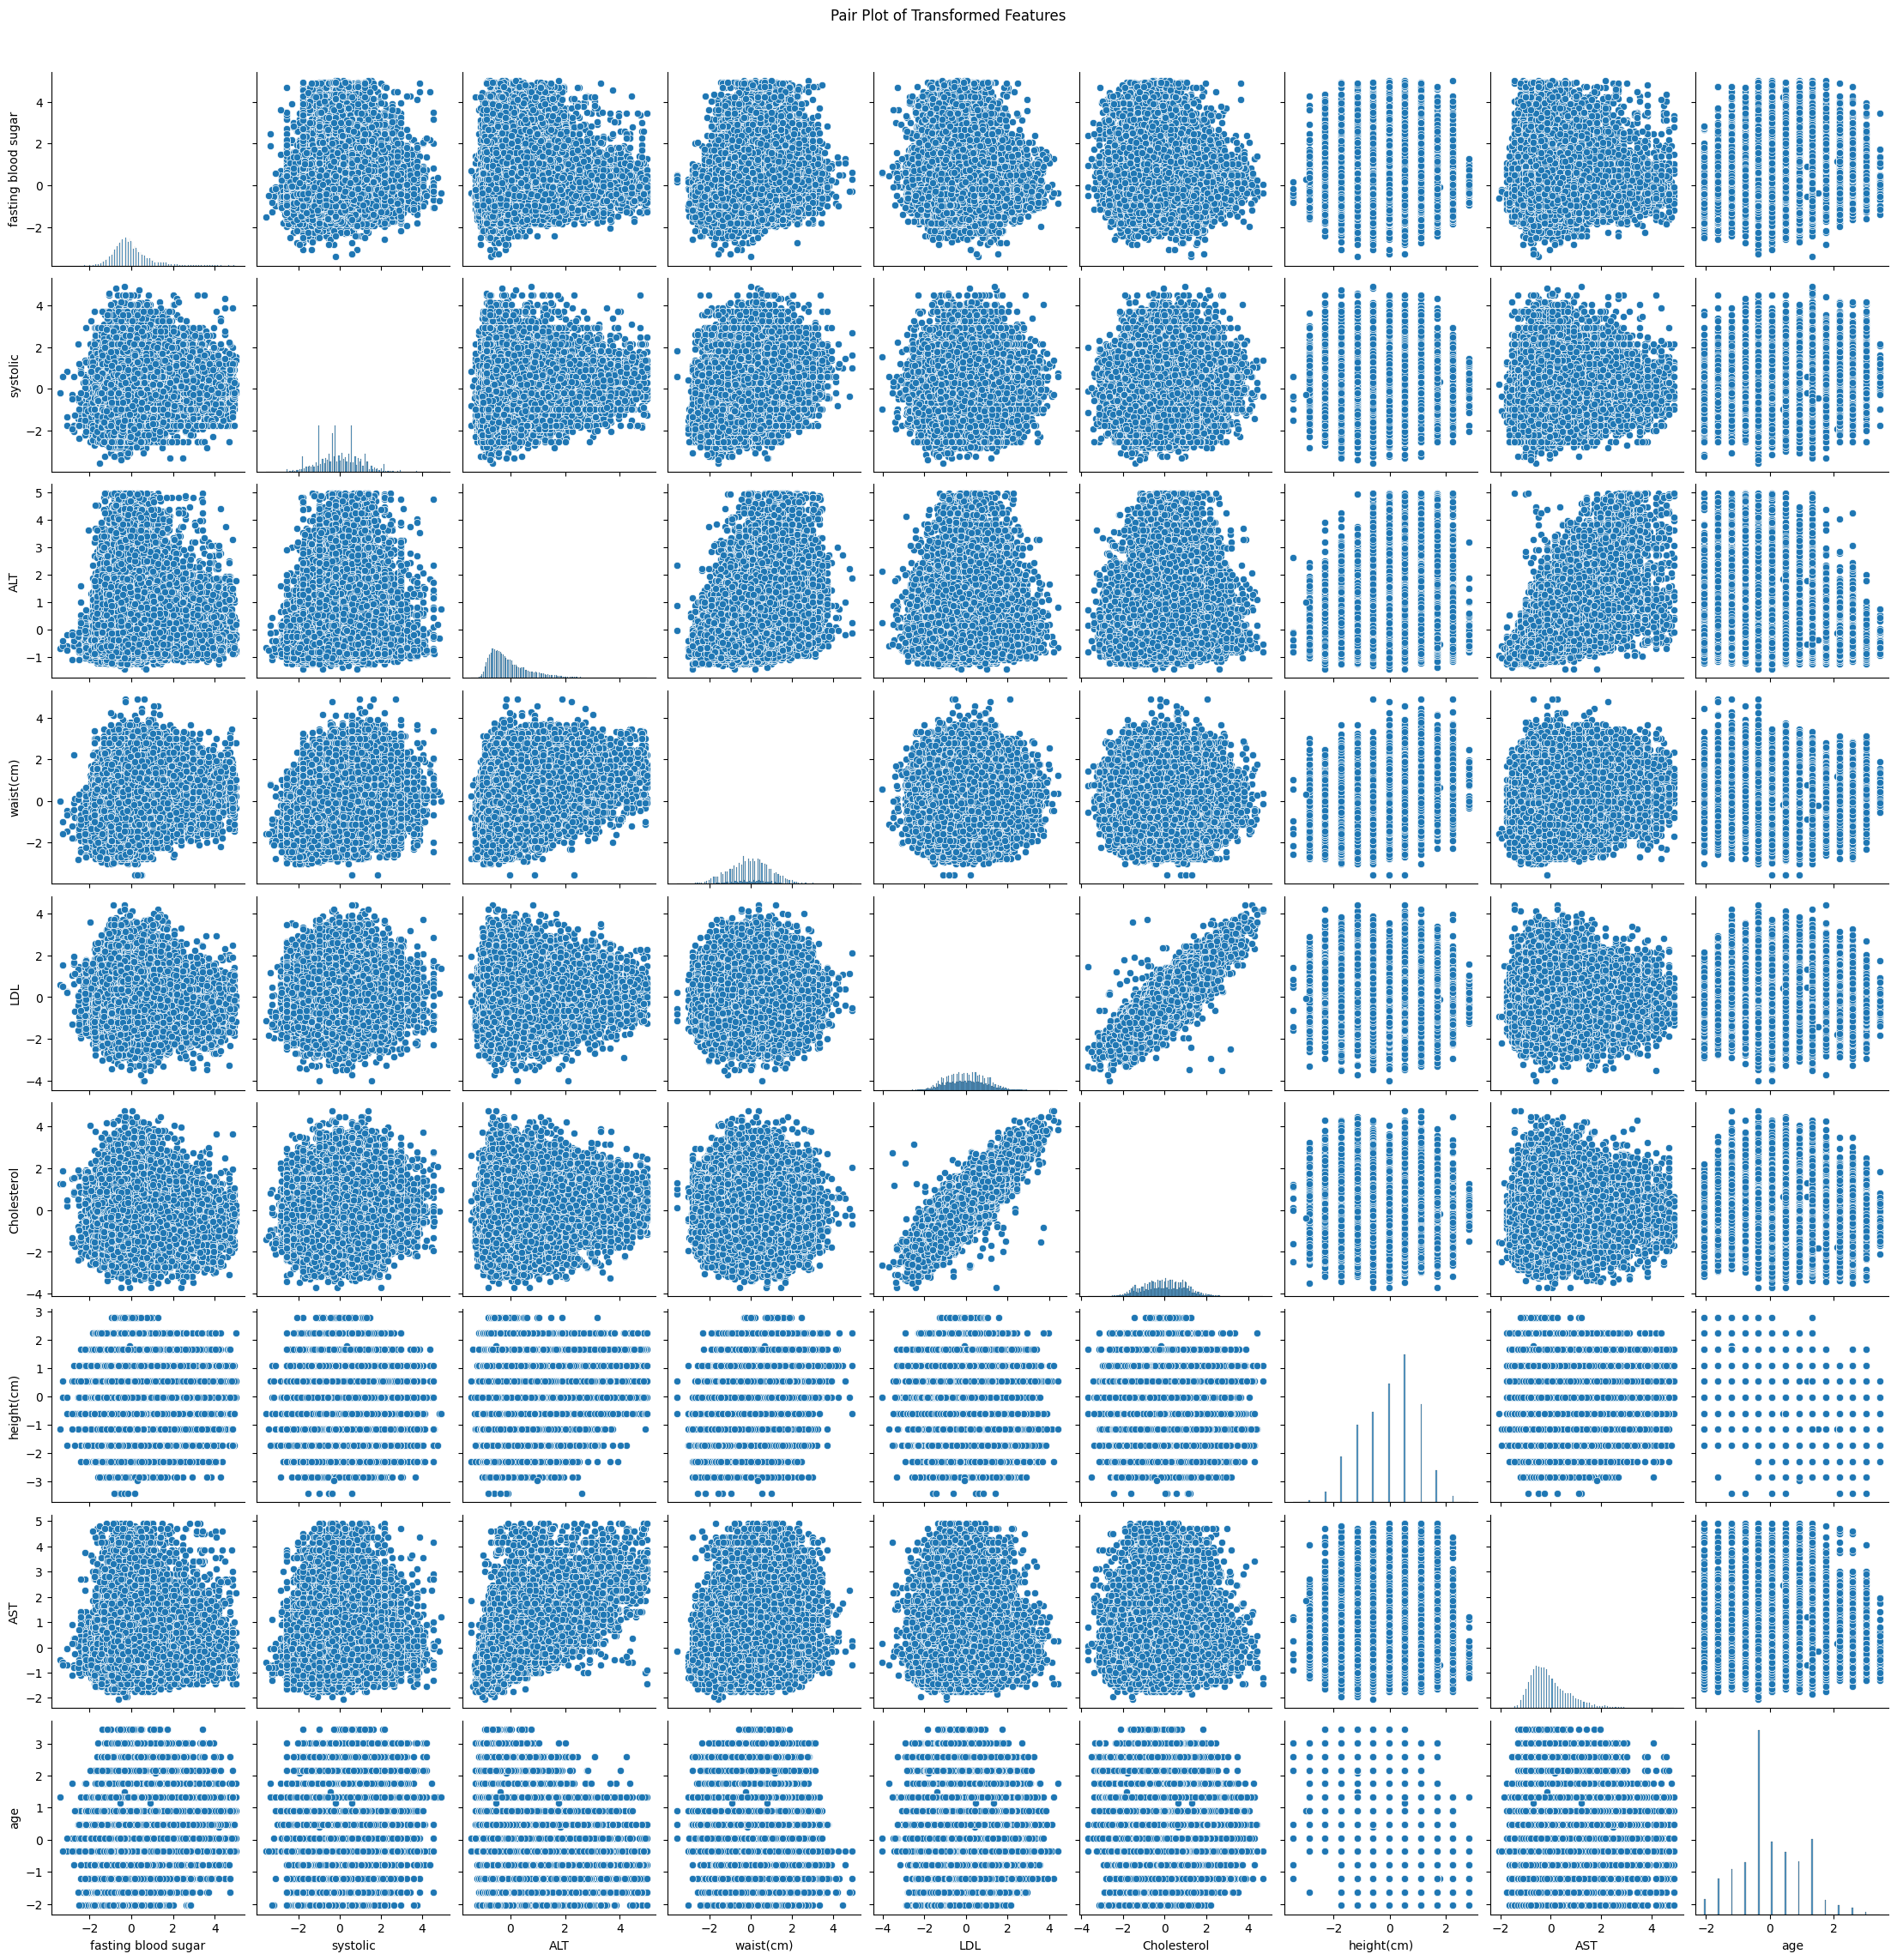

In [ ]:
sns.pairplot(filtered_features)
plt.suptitle('Pair Plot of Transformed Features', y=1.02)
plt.show()

pair plotting every 2 features

In [ ]:
def create_interaction_terms(df, correlation_threshold=0.7):
    df = df.copy()
    correlation_matrix = df.corr()
    high_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Create interaction terms for each high correlation pair
    for feature1, feature2 in high_correlation_pairs:
        interaction_term_name = f"{feature1}_{feature2}_interaction"
        df[interaction_term_name] = df[feature1] * df[feature2]

    return df
correlation_threshold = 0.7
filtered_features = create_interaction_terms(filtered_features, correlation_threshold)
print(filtered_features.head())


   fasting blood sugar  systolic       ALT  waist(cm)       LDL  Cholesterol  \
0            -0.283930  0.981702 -0.087326  -0.223489 -1.406581    -0.837985   
1             3.173413  1.845852 -0.199983   0.669577  0.404573    -0.063252   
2            -1.262423 -0.353802  0.250645  -0.223489 -0.767350    -0.626695   
3            -0.479628  0.667465  0.025331   2.455708 -0.447734    -0.556264   
4            -0.479628 -0.118125 -0.763267  -0.279305 -0.767350    -1.436643   

   height(cm)       AST       age  LDL_Cholesterol_interaction  
0   -0.030268 -0.371570  0.902985                     1.178694  
1   -0.030268  0.156700  2.169636                    -0.025590  
2    0.536694  0.156700 -2.052535                     0.480894  
3    1.670617 -0.582878 -0.785883                     0.249059  
4   -0.030268 -0.688532 -1.208100                     1.102408  


<h1>feature engineering<br>
multiplying the highly correlated features to make new ones called interactions

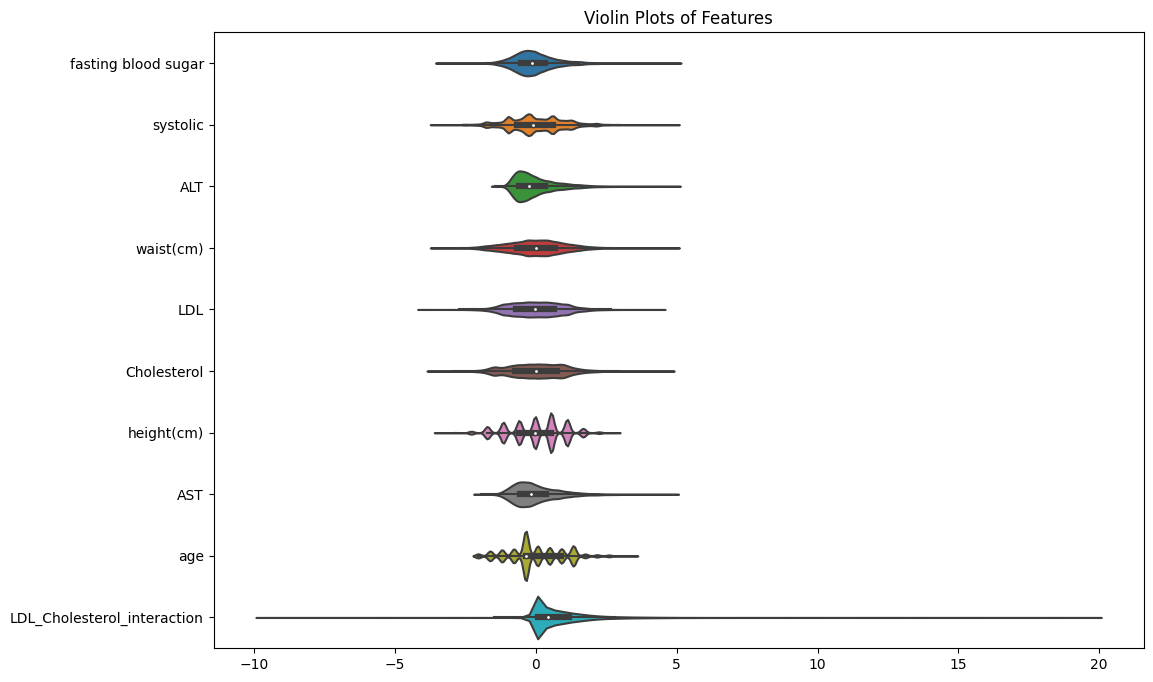

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_features, orient="h")
plt.title('Violin Plots of Features')
plt.show()

<h1>Multivariate


<h5> To solve the curse of dimentionality we use pca that captures the most significant variance in data and leads to improved model efficiency and generalization

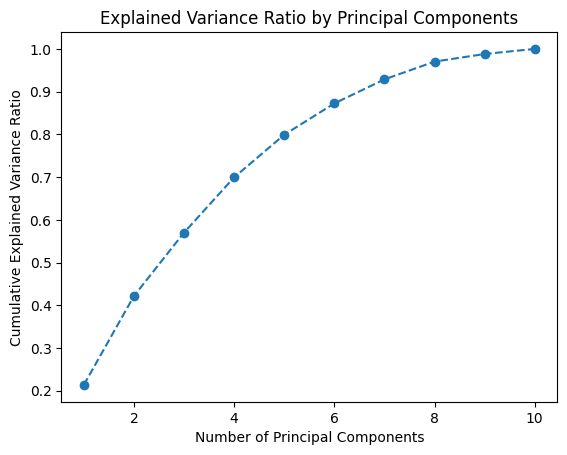

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(filtered_features)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()


In [ ]:
n_components = 6
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(filtered_features)

# Reconstruct the filtered features from the selected principal components
reconstructed_features = pca.inverse_transform(pca_result)
reconstructed_df = pd.DataFrame(reconstructed_features, columns=filtered_features.columns)

Combining the smoking column with the features

In [ ]:
combined_df = pd.concat([filtered_targets, reconstructed_df], axis=1)

saving it

In [ ]:
combined_df.to_csv("final_data_with_target.csv", index=False)